In [1]:
#Used Cars Scraping Practice

#The example website to make sure this topic won't be too difficult
#https://medium.com/analytics-vidhya/scraping-car-prices-using-python-97086c30cd65


In [ ]:
#Comments:
#Some of the cars from cars.com are not priced! remember to drop those
#
#Check for duplicates after merging second car website? (maybe vin number?)
#Add second page for more than just 100cars/website?
#

In [1]:
#Import required packages/libraries:
from bs4 import BeautifulSoup as bsoup
from selenium import webdriver
import requests
import pandas as pd
import re
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import emoji

Below is are the urls for the various car website pages that have used cars in Denver (80225 zip code).

In [2]:
#Scraping from cars.com (all used cars in Lakewood,CO)
#url_1 = "https://www.cars.com/shopping/results/?stock_type=used&makes%5B%5D=&models%5B%5D=&list_price_max=&maximum_distance=30&zip=80225"

#100 Cars per page in Denver zip code 80225 (cars.com):
url_1 = "https://www.cars.com/shopping/results/?list_price_max=&makes[]=&maximum_distance=30&models[]=&page=1&page_size=100&stock_type=used&zip=80225"

#100 Cars per page in Denver zip code 80225 (Autotrader.com):
url_2 = "https://www.autotrader.com/cars-for-sale/all-cars/denver-co-80225?dma=&searchRadius=50&isNewSearch=false&marketExtension=include&showAccelerateBanner=false&sortBy=relevance&numRecords=100"
#url_2 = "https://www.carvana.com/cars"#"https://www.autonation.com/cars-for-sale?cnd=USED%7CCPO"


In [3]:
response = requests.get(url_1)
response_autotrader = requests.get(url_2)
print(response.status_code)
print(response_autotrader.status_code)
#response.status_code

200
200


In [4]:
html_soup = bsoup(response.text, 'html.parser')
html_soup_autotrader = bsoup(response_autotrader.text, 'html.parser')
#print(html_soup)

### Cars.com data scraping, parsing, and dataframe creation:
We will first parse the data from Cars.com and build a dataframe.

In [5]:
#Response for Cars.com:
content_list = html_soup.find_all('div', attrs={'class': 'vehicle-card'})
#Used to sift through and find the div, span, h, etc. tags and names associated with our variables

#print(content_list)

In [6]:
#Extract Name, Mileage, and price from Cars.com Data:

names = []
for item in content_list:
    #names.append(item.find_all('h2', attrs={'class': "title"}))
    names.append(item.find('h2').getText())
#print(names)

miles = []
for item in content_list:
    #miles.append(item.find_all('div', attrs={'class': "mileage"}))
    miles.append(item.find('div', attrs={'class': "mileage"}).getText())
#print(miles)

price = []
for item in content_list:
    #price.append(item.find_all('span', attrs={'class': "primary-price"}))
    price.append(item.find('span', attrs={'class': "primary-price"}).getText())
#print(price)


In [7]:
#Combine Name, Mileage, and Prices into Dataframe:
data_cars = pd.DataFrame({"Name" : names, "Mileage" : miles, "Price" : price})[["Name", "Mileage", "Price"]]
data_cars

,Name,Mileage,Price
0,2020 Ford F-150 XLT,"62,231 mi.","$33,387"
1,2017 Maserati Levante S,"69,361 mi.","$38,993"
2,2022 GMC Canyon AT4 w/Leather,"4,203 mi.","$43,797"
3,2018 Subaru BRZ Limited,"46,345 mi.","$26,599"
4,2004 Pontiac GTO,"29,860 mi.","$18,998"
...,...,...,...
96,2020 Toyota Sequoia TRD Pro,"34,932 mi.","$60,000"
97,2021 Genesis GV80 3.5T,"7,689 mi.","$65,999"
98,2022 Jeep Wagoneer Series II,"2,637 mi.","$72,503"
99,2020 Mercedes-Benz GLE 450 AWD 4MATIC,"29,381 mi.","$60,399"


In [8]:
#Convert Mileage to number:
def mileage(row):
    return int(row.split(" mi.")[0].replace(',',''))

data_cars['Mileage'] = data_cars['Mileage'].apply(mileage)

#data
#data.dtypes

In [9]:
#Convert Price to Number:
def price(row):
    #print(row)
    if row == 'Not Priced':
        return 0
    else:
        return int(row.split("$")[1].replace(',', ''))

data_cars['Price'] = data_cars['Price'].apply(price)

#print(data)
#data.dtypes

In [10]:
#Drop any cars without a price value:
data_cars = data_cars[data_cars['Price']!='Not Priced']

#Add website column
data_cars['website'] = 'Cars.com'
data_cars

,Name,Mileage,Price,website
0,2020 Ford F-150 XLT,62231,33387,Cars.com
1,2017 Maserati Levante S,69361,38993,Cars.com
2,2022 GMC Canyon AT4 w/Leather,4203,43797,Cars.com
3,2018 Subaru BRZ Limited,46345,26599,Cars.com
4,2004 Pontiac GTO,29860,18998,Cars.com
...,...,...,...,...
96,2020 Toyota Sequoia TRD Pro,34932,60000,Cars.com
97,2021 Genesis GV80 3.5T,7689,65999,Cars.com
98,2022 Jeep Wagoneer Series II,2637,72503,Cars.com
99,2020 Mercedes-Benz GLE 450 AWD 4MATIC,29381,60399,Cars.com


### Autotrader.com data scraping, parsing, and dataframe creation:

In [11]:
#print(html_soup_autotrader)

In [12]:
#Response for Autotrader.com:
content_list_autotrader = html_soup_autotrader.find_all('script', attrs={'data-cmp': 'lstgSchema'})
#print(content_list_autotrader[1])

In [13]:
#Extract Name, Mileage, and price from Autotrader.com Data:

names = []
for item in content_list_autotrader:
    s = str(item)
    names.append(' '.join(s.split('name":"')[1].split('",')[0].split(' ')[1:]))
#print(names)

miles = []
for item in content_list_autotrader:
    s = str(item)
    s = s.split('value":"')[1].split('"}')[0].replace(',', '')
    if s == '':
        miles.append(0)
    else:
        miles.append(int(s))
        #miles.append(int(s.split('value":"')[1].split('"}')[0].replace(',', '')))
        #miles.append(s.split('value":"')[1].split('"}')[0].replace(',', ''))
#print(miles)

price = []
for item in content_list_autotrader:
    p = str(item)
    p = p.split('price":')[1].split(',')[0]
    if p =='':
        price.append(0)
    else:
        #price.append(int(s.split('price":')[1].split(',')[0]))
        price.append(int(p))
#print(price)


In [14]:
#Combine Name, Mileage, and Prices into Dataframe:
data_autotrader = pd.DataFrame({"Name" : names, "Mileage" : miles, "Price" : price})[["Name", "Mileage", "Price"]]
data_autotrader['website'] = 'Autotrader.com'
data_autotrader

,Name,Mileage,Price,website
0,2022 BMW 750i xDrive w/ Luxury Rear Seating Pa...,8267,89899,Autotrader.com
1,2018 Honda CR-V Touring,49812,29079,Autotrader.com
2,2018 Subaru Forester 2.0XT Touring,36886,31490,Autotrader.com
3,2015 Chevrolet Colorado LT w/ LT Convenience P...,55448,23000,Autotrader.com
4,2019 Volkswagen Jetta S w/ Driver Assistance P...,13406,20999,Autotrader.com
...,...,...,...,...
98,2019 Jeep Grand Cherokee Altitude,27525,33399,Autotrader.com
99,2019 MAZDA CX-5 Touring,26797,25998,Autotrader.com
100,2018 Dodge Charger SXT Plus w/ Quick Order Pac...,13993,26998,Autotrader.com
101,2017 Toyota Prius Prime Advanced,37960,28998,Autotrader.com


### Carmax data pulling, data scraping, parsing, and dataframe creation:

In [15]:
url_3 = "https://www.carmax.com/cars/all?location=denver+co+80121"
#executable_path = '/mnt/c/users/ainsley/desktop/tools1/chromedriver.exe'
#response_3 = webdriver.Chrome(executable_path=executable_path)
response_3 = webdriver.Chrome()
response_3.get(url_3)

html_soup_3 = bsoup(response_3.page_source, 'html.parser')

content_list_3 = html_soup_3.find_all('article', attrs={'class': 'car-tile'})
print(content_list_3)

/tmp/ipykernel_225/87586368.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  response_3 = webdriver.Chrome(executable_path=executable_path)


[<article aria-label="Select 2014 Dodge Journey Limited with stock number 23296560" class="car-tile" data-clickprops="Element type: Car Tile,StockNumber: 23296560,YMM: 2014 Dodge Journey,Price: 15998,Marked Down: null,Coming Soon: false" data-id="23296560" data-ignore-anchor-tag-rule="true" data-position="0" role="link" tabindex="0"><div aria-label="select car" class="tile-shell"><div class="car-tile--images"><div class="car-tile-heart"><button aria-label="Add favorite" type="button"></button></div><div class="image-carousel" data-clickprops="Element type: Car Tile Image,StockNumber: 23296560"><div class="image-carousel--viewer"><button aria-label="left arrow button" class="image-carousel--nav left-nav disabled" data-clickprops="Element type: Image Carousel Nav" data-direction="left" type="button"><svg aria-hidden="true" class="image-carousel--nav-arrow" focusable="false" viewbox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path d="M15.41 16.09l-4.58-4.59 4.58-4.59L14 5.5l-6 6 6 6z"

In [50]:
names_3 = []
for item in content_list_3:
    names_3.append(item.find('span', attrs={'class': "year-make"}).text + ' ' 
                 + item.find('span', attrs={'class': "model-trim"}).text)
print(names_3)
miles_3 = []
for item in content_list_3:
    miles_3.append(item.find('span', attrs={'class': "miles"}).text.replace('K mi',',000'))
print(miles_3)

price_3 = []
for item in content_list_3:
    price_3.append(item.find('span', attrs={'class': "price"}).text.replace('*',''))

['2014 Dodge Journey Limited', '2014 Chevrolet Malibu LTZ', '2022 Honda Accord LX', '2011 Nissan Versa ', '2012 Hyundai Santa Fe GLS', '2021 Tesla Model Y PERFORMANCE', '2018 Land Rover Discovery Sport HSE', '2018 BMW X1 SDrive28i', '2014 Hyundai Sonata GLS', '2015 Chevrolet Malibu LT', '2012 Ford Mustang GT', '2013 Dodge Journey SE', '2019 Jeep Wrangler Unlimited Sport', '2014 Mercedes-Benz C300 LUXURY', '2012 Cadillac CTS Premium', '2019 Mercedes-Benz A220 ', '2012 Honda Civic EX', '2011 Lexus RX 350 ', '2011 Ford Fusion SE', '2018 Mercedes-Benz C300 ', '2018 Dodge Durango SRT', '2012 Chevrolet Corvette ']
['98,000', '120,000', '7,000', '81,000', '111,000', '17,000', '32,000', '41,000', '95,000', '100,000', '80,000', '78,000', '29,000', '68,000', '48,000', '28,000', '116,000', '118,000', '45,000', '33,000', '38,000', '30,000']


In [56]:
data_carmax = pd.DataFrame({"Name" : names_3, "Mileage" : miles_3, "Price" : price_3})[["Name", "Mileage", "Price"]]

In [57]:
#Convert Mileage and Price into integers
data_carmax.Mileage = data_carmax.Mileage.str.replace(',','').astype(int)

data_carmax.Price = data_carmax.Price.str.replace(',','')
data_carmax.Price = data_carmax.Price.str.replace('$','')

/tmp/ipykernel_225/1430115406.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_carmax.Price = data_carmax.Price.str.replace('$','')


In [59]:
data_carmax['website'] = 'Carmax.com'

### Join the Cars.com dataframe, the Autotrader.com dataframe, and the Carmax dataframe

In [60]:
#Index values have duplicates here....

#data.append(data_autotrader)
#data
data = pd.concat([data_cars, data_autotrader, data_carmax])
data

,Name,Mileage,Price,website
0,2020 Ford F-150 XLT,62231,33387,Cars.com
1,2017 Maserati Levante S,69361,38993,Cars.com
2,2022 GMC Canyon AT4 w/Leather,4203,43797,Cars.com
3,2018 Subaru BRZ Limited,46345,26599,Cars.com
4,2004 Pontiac GTO,29860,18998,Cars.com
...,...,...,...,...
17,2011 Lexus RX 350,118000,17998,Carmax.com
18,2011 Ford Fusion SE,45000,14998,Carmax.com
19,2018 Mercedes-Benz C300,33000,29998,Carmax.com
20,2018 Dodge Durango SRT,38000,59998,Carmax.com


In [260]:
data.dtypes

Name       object
Mileage     int64
Price       int64
website    object
dtype: object

In [261]:
#NEED TO CHECK FOR ZERO VALUES (empty strings)

#Check for null values
data.isnull().sum()

Name       0
Mileage    0
Price      0
website    0
dtype: int64

In [29]:
#makes = open("Car_Manufacturers.txt").read()

data['Name'].str.extract(r''+test)
data['Make'] = data['Name'].str.extract(r''+makes_str)
#data.Name
#test
data.Make[pd.isnull(data['Make'])==True]

NameError: name 'test' is not defined

In [262]:
#Pull Year and Make out of Name:

#Import list of popular makes from online:
makes = open("Car_Manufacturers.txt").read()

makes_str = '(' + makes.replace('\n','|') + ')'
data['Make'] = data['Name'].str.extract(r''+makes_str)

#Pull out year from name column:
year_regex = re.compile('^\d.[0-9]*', re.DOTALL)

def year(row):
    if re.findall(year_regex, row)==[]:
        return None
    else:
        return re.findall(year_regex, row)[0]

data['Year'] = data['Name'].apply(year)

def Model(df):
    if pd.isnull(df['Make']) != True:
        #return df['Name'].replace({df['Name']:{df['Make']:'', df['Year']:''}}) <-cant get multiple replace to work
        one = df['Name'].replace(df['Make'], '')
        if df['Year'] != None:
            return one.replace(df['Year'], '')

data['Model'] = data.apply(Model, axis=1)


#Drop Name column:
data.drop('Name', axis=1, inplace=True)

data


,Mileage,Price,website,Make,Year,Model
0,39699,39387,Cars.com,Nissan,2020,NV Cargo NV2500 HD SV V6/SV V8
1,64746,33980,Cars.com,Jeep,2019,Wrangler Unlimited Sport
2,11220,112992,Cars.com,Porsche,2020,Panamera E-Hybrid Sport Turismo 4
3,22986,41637,Cars.com,Jaguar,2020,E-PACE SE
4,92262,17000,Cars.com,GM,2016,C Acadia SLT-1
...,...,...,...,...,...,...
98,38378,45949,Autotrader.com,Cadillac,2017,Escalade ESV Premium Luxury
99,4442,53688,Autotrader.com,Toyota,2022,Tundra SR5
100,3814,55599,Autotrader.com,Toyota,2021,Tundra Platinum
101,8179,66599,Autotrader.com,Tesla,2022,Model Y Performance


/Users/edwardguevel/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mileage', ylabel='Price'>

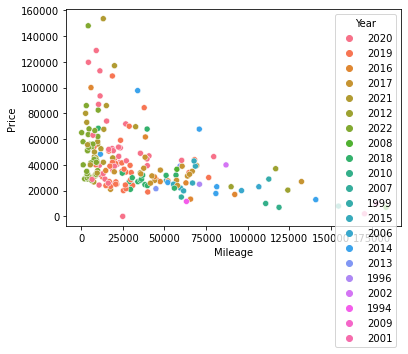

In [272]:
#Plot Mileage v. Price:
sns.scatterplot(data['Mileage'], data['Price'], hue=data['Year'])

/Users/edwardguevel/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


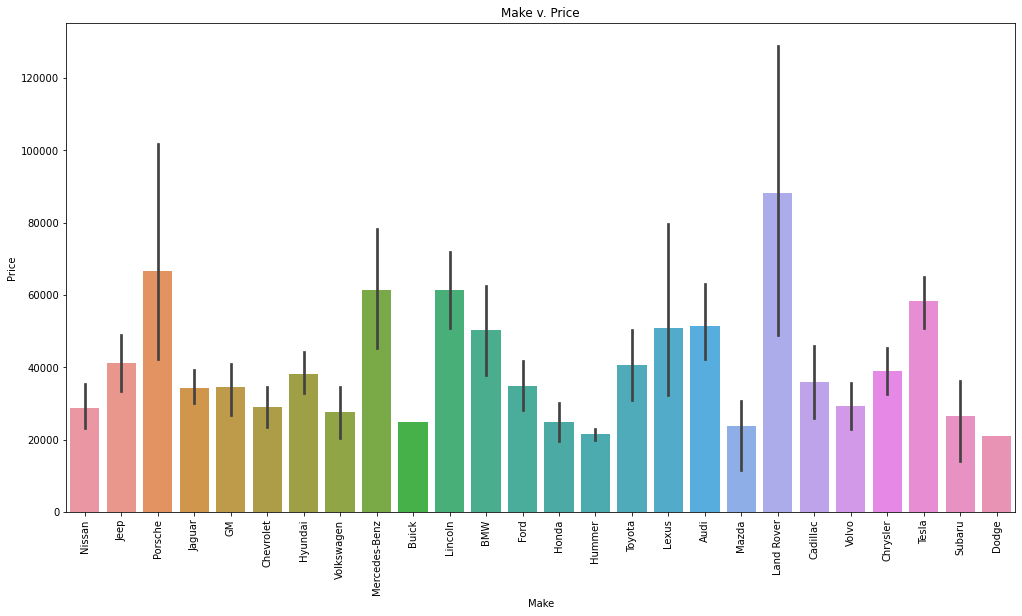

In [264]:
#Plot bar graph of price v. make:
fig, ax = plt.subplots(figsize=(17,9 ))
sns.barplot(data['Make'], data['Price'], ax=ax)
ax.set_title('Make v. Price')
ax.set_xlabel('Make')
ax.set_ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#re.findall(year_regex, data['Name'][0])
#data['Name'][0]

#re.findall(year_regex, '2012 Chevrolet Suburban 1500 LTZ')
#data['Make'].unique()

In [265]:
#Generate a Rating Function:

#Compute average price for each make:
#avg_make_price = movie.movie_title.str.len().groupby([movie.years, movie.Action]).mean()
avg_make_price = data.Price.groupby(data.Make).mean()
avg_make_price_dict = avg_make_price.to_dict()
#print(avg_make_price)
#avg_make_price['Ford']

#Function for computing comparative rating:
#def rating(df):
    #for m in makes:
        #if df['Make'] == m:
            #return df['Price']/avg_make_price[m]/(df['Mileage']/10000)*(int(df['Year'])/1000)
    #return df['Price']/avg_make_price[]

#data['Rating'] = data.apply(rating, axis=1)    
data['Rating'] = data['Price']/data['Make'].map(avg_make_price_dict)/(data['Mileage']/10000)*(data['Year'].astype(int)/500)
data

#data['Price'][0]/avg_make_price['Chevrolet']*(data['Mileage'][0]/100000)*(int(data['Year'][0])/1000)

,Mileage,Price,website,Make,Year,Model,Rating
0,39699,39387,Cars.com,Nissan,2020,NV Cargo NV2500 HD SV V6/SV V8,1.395581
1,64746,33980,Cars.com,Jeep,2019,Wrangler Unlimited Sport,0.515739
2,11220,112992,Cars.com,Porsche,2020,Panamera E-Hybrid Sport Turismo 4,6.112442
3,22986,41637,Cars.com,Jaguar,2020,E-PACE SE,2.142641
4,92262,17000,Cars.com,GM,2016,C Acadia SLT-1,0.214589
...,...,...,...,...,...,...,...
98,38378,45949,Autotrader.com,Cadillac,2017,Escalade ESV Premium Luxury,1.344563
99,4442,53688,Autotrader.com,Toyota,2022,Tundra SR5,12.063207
100,3814,55599,Autotrader.com,Toyota,2021,Tundra Platinum,14.542383
101,8179,66599,Autotrader.com,Tesla,2022,Model Y Performance,5.639655


In [266]:

bin_title = [emoji.emojize(':star:'),emoji.emojize(':star::star:'),emoji.emojize(':star::star::star:'),
             emoji.emojize(':star::star::star::star:'),emoji.emojize(':star::star::star::star::star:')]

data['Star_Rating'] = pd.qcut(data['Rating'],q=5,labels=bin_title)
data

,Mileage,Price,website,Make,Year,Model,Rating,Star_Rating
0,39699,39387,Cars.com,Nissan,2020,NV Cargo NV2500 HD SV V6/SV V8,1.395581,⭐⭐⭐
1,64746,33980,Cars.com,Jeep,2019,Wrangler Unlimited Sport,0.515739,⭐
2,11220,112992,Cars.com,Porsche,2020,Panamera E-Hybrid Sport Turismo 4,6.112442,⭐⭐⭐⭐⭐
3,22986,41637,Cars.com,Jaguar,2020,E-PACE SE,2.142641,⭐⭐⭐
4,92262,17000,Cars.com,GM,2016,C Acadia SLT-1,0.214589,⭐
...,...,...,...,...,...,...,...,...
98,38378,45949,Autotrader.com,Cadillac,2017,Escalade ESV Premium Luxury,1.344563,⭐⭐⭐
99,4442,53688,Autotrader.com,Toyota,2022,Tundra SR5,12.063207,⭐⭐⭐⭐⭐
100,3814,55599,Autotrader.com,Toyota,2021,Tundra Platinum,14.542383,⭐⭐⭐⭐⭐
101,8179,66599,Autotrader.com,Tesla,2022,Model Y Performance,5.639655,⭐⭐⭐⭐


In [273]:
#More EDA?
#Compare average rating of the two websites?
#